# Preprocess HBEC IFN data

For now, isolate the Type I interferons

In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data_path = '/data_volume/ifn_hbec/'

In [3]:
%matplotlib inline

### Read the data

In [8]:
adata = sc.read(data_path + 'HBEC_condition_assigned_deep.h5ad')
adata = adata[adata.obs.condition != 'unassigned'].copy()

In [9]:
adata.obs['donor'] = adata.obs['condition'].apply(lambda x: x.split('_')[0])
adata.obs['stim'] = adata.obs['condition'].apply(lambda x: x.split('_')[1])
adata.obs['time'] = adata.obs['condition'].apply(lambda x: x.split('_')[2] if 'control' not in x else 0)

In [10]:
adata.shape

(80654, 36741)

In [11]:
# adata = adata[(adata.obs['stim'].isin(['control', 'alpha', 'beta']))]

### Slice out mRNA from ADT

In [12]:
adt_adata = adata[:, adata.var.query('feature_types == "Antibody Capture" & ~gene_ids.str.contains("hash").values').index].copy()
rna_adata = adata[:, adata.var.query('feature_types != "Antibody Capture"').index].copy()

In [13]:
rna_adata.shape

(80654, 36601)

In [15]:
rna_adata.obs.stim.value_counts()/rna_adata.shape[0]

beta       0.249882
alpha      0.242964
gamma      0.241501
lambda     0.227986
control    0.037667
Name: stim, dtype: float64

### Process RNA data

In [46]:
rna_adata.obs.head(5)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCCAAGGAAGTAG-1,1700,donor0,SNG,0,hash-10,d2513_lambda_9,d2513,lambda,9,4297,4297,12191.0,1394.0,11.434665,3
AAACCCAAGGGACTGT-1,839,donor0,SNG,0,hash-3,d2513_alpha_24,d2513,alpha,24,2171,2171,7270.0,386.0,5.309491,5
AAACCCACAATCTGCA-1,1130,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,3016,3016,9544.0,516.0,5.406538,0
AAACCCACACGTTCGG-1,989,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,2748,2748,8248.0,583.0,7.068380,19
AAACCCACAGAACTAA-1,997,donor1,SNG,0,hash-8,d2614_gamma_48,d2614,gamma,48,2885,2885,7765.0,729.0,9.388281,14


In [16]:
sc.pp.filter_cells(rna_adata, min_genes=50)
# sc.pp.filter_genes(rna_adata, min_cells=500)

In [17]:
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [18]:
# rna_adata = rna_adata[rna_adata.obs.n_genes_by_counts < 2500, :]
rna_adata = rna_adata[rna_adata.obs.pct_counts_mt < 20, :]

In [19]:
rna_adata.shape

(69958, 36601)

In [20]:
rna_adata.obs.stim.value_counts()/rna_adata.shape[0]

beta       0.261271
alpha      0.256797
gamma      0.234626
lambda     0.213571
control    0.033735
Name: stim, dtype: float64

In [21]:
rna_adata_counts = rna_adata.copy()

In [22]:
sc.pp.normalize_total(rna_adata, target_sum=1e4)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
sc.pp.log1p(rna_adata)

In [24]:
rna_adata.raw = rna_adata

In [25]:
sc.pp.highly_variable_genes(rna_adata, min_mean=0.01, max_mean=3, min_disp=0.5, batch_key='donor')

... storing 'donor' as categorical
... storing 'stim' as categorical
... storing 'time' as categorical


In [26]:
rna_adata = rna_adata[:, rna_adata.var.highly_variable & ~rna_adata.var.mt]

In [27]:
rna_adata.raw.shape

(69958, 36601)

In [28]:
sc.pp.regress_out(rna_adata, ['total_counts', 'pct_counts_mt'])

In [29]:
# sc.pp.combat(rna_adata, key='donor')

In [30]:
sc.pp.scale(rna_adata, max_value=10)

In [31]:
sc.tl.pca(rna_adata, svd_solver='arpack')

In [32]:
sc.pp.neighbors(rna_adata, n_neighbors=30, n_pcs=40)


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/envs/single_cell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../

In [33]:
sc.tl.umap(rna_adata)

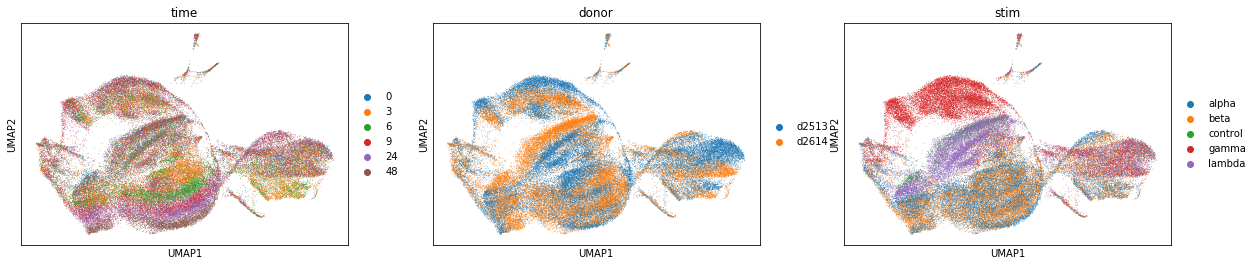

In [34]:
sc.pl.umap(rna_adata, color=['time', 'donor', 'stim'])

### Clustering

In [35]:
sc.tl.leiden(rna_adata, resolution=1.5)

In [36]:
rna_adata.obs.head(5)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCCAAGGAAGTAG-1,1700,donor0,SNG,0,hash-10,d2513_lambda_9,d2513,lambda,9,4297,4297,12191.0,1394.0,11.434665,3
AAACCCAAGGGACTGT-1,839,donor0,SNG,0,hash-3,d2513_alpha_24,d2513,alpha,24,2171,2171,7270.0,386.0,5.309491,5
AAACCCACAATCTGCA-1,1130,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,3016,3016,9544.0,516.0,5.406538,0
AAACCCACACGTTCGG-1,989,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,2748,2748,8248.0,583.0,7.068380,19
AAACCCACAGAACTAA-1,997,donor1,SNG,0,hash-8,d2614_gamma_48,d2614,gamma,48,2885,2885,7765.0,729.0,9.388281,14


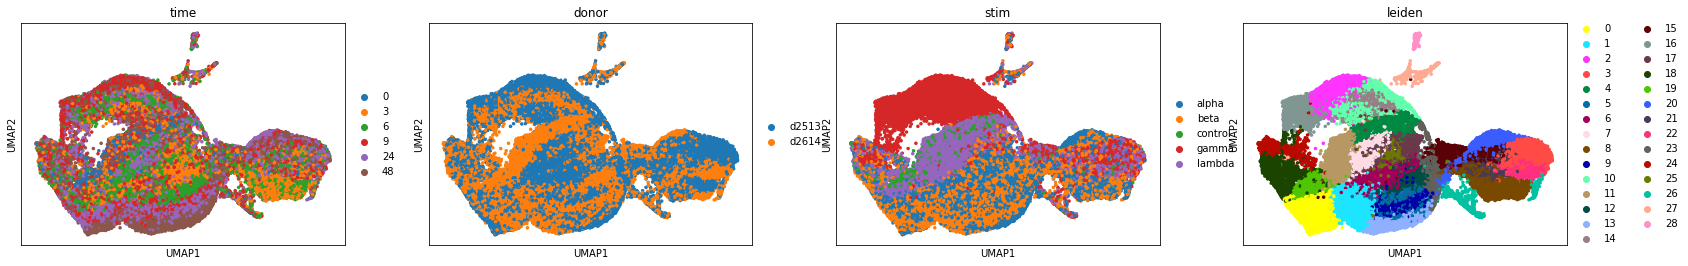

In [37]:
sc.pl.umap(rna_adata, color=['time', 'donor', 'stim', 'leiden'], s=50)

### Identify cell types using marker genes

In [38]:
import pandas as pd

In [39]:
marker_genes = ['KRT5', 'DAPL1', 'TP63', 'KRT4', 'KRT13', 'SCGB1A1','KRT15', 'LYPD2','FOXJ1', 'CCDC113','CCDC153',
                'MLF1', 'LZTFL1','CHGA', 'ASCL1', 'POU2F3', 'AVIL', 'GNAT3','FOXI1', 'CFTR', 'ASCL3', 'MUC5AC', 'MUC5B', 'GP2','SPDEF']


In [40]:
marker_matrix = rna_adata.raw[:, marker_genes].X

In [41]:
marker_df = pd.DataFrame(marker_matrix.toarray(), columns=marker_genes)
marker_df['cluster'] = rna_adata.obs.leiden.values
marker_df = marker_df.groupby('cluster')[marker_genes].mean()
marker_df[marker_genes] = marker_df[marker_genes]/marker_df[marker_genes].max(axis=0)

In [42]:
adt_marker_df = pd.DataFrame(adt_adata[rna_adata.obs.index, -11:].X.toarray(), columns=adt_adata.var.tail(11).index)
adt_marker_df['cluster'] = rna_adata.obs.leiden.values
adt_marker_df = adt_marker_df.groupby('cluster').mean()
# adt_marker_df = adt_marker_df/adt_marker_df.max(axis=0)

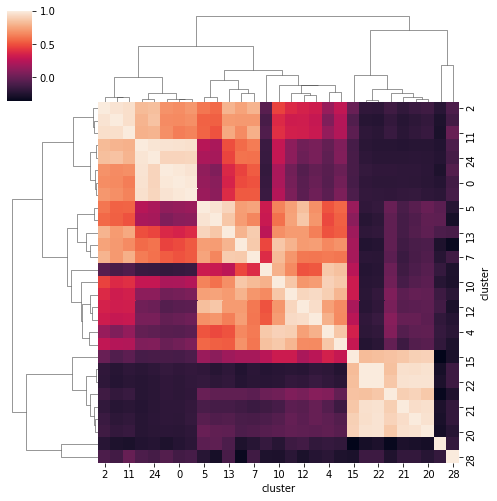

In [45]:
cg = sns.clustermap(marker_df.T.corr(), figsize=(7,7))

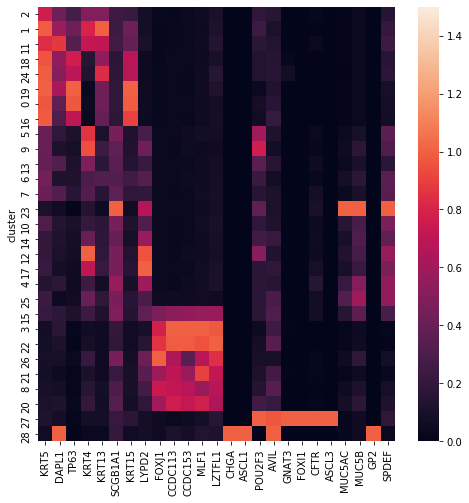

In [44]:
order = cg.dendrogram_row.reordered_ind
plt.figure(figsize=(8,8))
sns.heatmap(marker_df.iloc[order, :], vmax=1.5)

In [58]:
cell_type_converter = \
    ['basal' for i in range(8)] + \
    ['basal/club' for i in range(5)] + \
    ['goblet'] + \
    ['basal/club' for i in range(6)] + \
    ['ciliated' for i in range(7)] + \
    ['ionocyte/tuft'] + ['neuroendo']
cell_type_converter = dict(zip(order, cell_type_converter))

In [59]:
rna_adata.obs['cell_type'] = rna_adata.obs['leiden'].apply(lambda x: cell_type_converter[int(x)])

... storing 'cell_type' as categorical


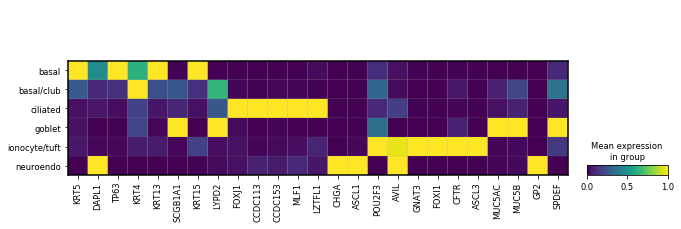

In [60]:
sc.pl.matrixplot(rna_adata, marker_genes, groupby='cell_type', standard_scale='var')

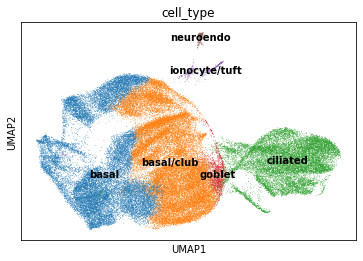

In [61]:
sc.pl.umap(rna_adata, color='cell_type', legend_loc='on data')

### Save the objects

In [62]:
rna_adata.write(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [63]:
rna_adata_counts.obs = rna_adata.obs
rna_adata_counts.write(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

### Make plots for figure

In [4]:
rna_adata = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

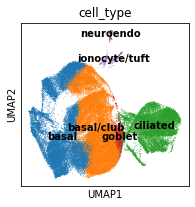

In [8]:
fig, ax = plt.subplots(figsize=(3,3))
sc.pl.umap(rna_adata, color='cell_type', legend_loc='on data', ax=ax)

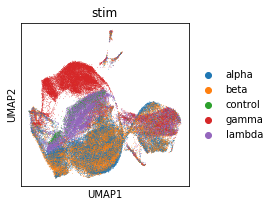

In [11]:
fig, ax = plt.subplots(figsize=(3,3))
sc.pl.umap(rna_adata, color='stim', ax=ax)

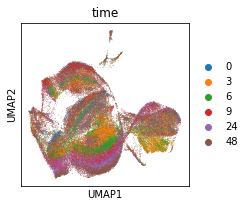

In [12]:
fig, ax = plt.subplots(figsize=(3,3))
sc.pl.umap(rna_adata, color='time', ax=ax)

### Diagram figures

In [15]:
import scipy.stats as stats
import numpy as np

(-1.25, 26.25, -0.03989350851217792, 0.8377636787557362)

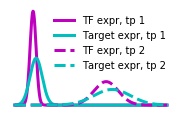

In [57]:
# Simple regulation
values = np.linspace(0, 25, 1000)
x1 = stats.norm.pdf(loc=3, scale=0.5, x=values)
y1 = stats.norm.pdf(loc=3.5, scale=1, x=values)

x2 = stats.norm.pdf(loc=15, scale=2, x=values)
y2 = stats.norm.pdf(loc=16, scale=3, x=values)

plt.figure(figsize=(3, 1.9))
plt.plot(values, x1, color='m', label='TF expr, tp 1', lw=3)
plt.plot(values, y1, color='c', label='Target expr, tp 1', lw=3)

plt.plot(values, x2, '--', color='m', label='TF expr, tp 2', lw=3)
plt.plot(values, y2, '--', color='c', label='Target expr, tp 2', lw=3)
plt.legend(frameon=False, fontsize='medium')
plt.axis('off')

(-0.5, 10.5, -0.06648704897232209, 1.396228028418764)

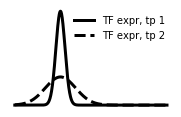

In [69]:
values = np.linspace(0, 10, 1000)

x1 = stats.norm.pdf(loc=3, scale=0.3, x=values)
x2 = stats.norm.pdf(loc=3, scale=1, x=values)
plt.figure(figsize=(3, 1.9))
plt.plot(values, x1, color='k', label='TF expr, tp 1', lw=3)
plt.plot(values, x2, '--',color='k', label='TF expr, tp 2', lw=3)
plt.legend(frameon=False, fontsize='medium')
plt.axis('off')